In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style="darkgrid")

In [116]:
train_a = pd.read_parquet('../data/A/train_targets.parquet')
X_train_estimated = pd.read_parquet('../data/A/X_train_estimated.parquet')
X_train_observed = pd.read_parquet('../data/A/X_train_observed.parquet')
X_test_estimated = pd.read_parquet('../data/A/X_test_estimated.parquet')

In [182]:
# Clean up feature-set for training data

X_train = X_train_observed.copy()
X_train = X_train.rename(columns={"date_forecast": "time"}).set_index("time").drop(columns=["date_calc"], errors="ignore")
X_train = X_train.resample('1H').mean().sort_index()
X_train.index = pd.to_datetime(X_train.index)

print("Shape:      ", X_train.shape)
print("Start:      ", X_train.index[0])
print("End:        ", X_train.index[-1])
print("Features:   ")
X_train.describe()


Shape:       (29668, 45)
Start:       2019-06-02 22:00:00
End:         2022-10-21 01:00:00
Features:   


,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
count,29668.000000,29668.000000,24466.000000,2.966800e+04,29668.000000,27800.000000,29668.000000,29668.000000,29668.000000,2.966800e+04,...,29668.000000,29668.000000,29668.000000,29668.000000,29668.000000,29668.000000,29668.000000,29668.000000,29668.000000,29668.000000
mean,6.652534,1.249065,2931.677002,5.993866e+05,166.496201,1749.091187,0.022398,276.823273,44.917145,1.617016e+05,...,179.625824,1.528661,0.059086,280.708466,74.399208,32447.103516,3.043158,0.756734,0.517449,0.000019
std,2.795361,0.036304,2571.665527,8.774904e+05,244.372955,1818.635864,0.180971,6.700054,64.514595,2.294851e+05,...,98.169510,24.108994,0.106667,6.572037,33.178200,17827.437500,1.772537,2.850567,1.842632,0.001240
min,0.700000,1.145000,27.849998,0.000000e+00,0.000000,27.900000,-1.000000,251.074997,0.000000,0.000000e+00,...,6.983000,-49.893997,0.000000,259.000000,0.000000,159.675003,0.025000,-7.225000,-8.400000,0.000000
25%,4.450000,1.224500,1116.481201,0.000000e+00,0.000000,596.250000,0.000000,272.075012,0.000000,0.000000e+00,...,93.627377,-14.932625,0.000000,275.924988,55.168750,15976.143799,1.675000,-1.400000,-0.725000,0.000000
50%,6.300000,1.246500,1908.087524,4.105412e+04,9.925000,1174.750000,0.000000,277.150024,4.737500,2.604512e+04,...,180.101997,1.150750,0.000000,280.650024,93.025002,36148.113281,2.700000,0.425000,0.500000,0.000000
75%,8.600000,1.272500,4035.006348,1.025223e+06,291.718758,2096.600098,0.000000,281.950012,76.275002,2.739429e+05,...,266.025620,19.170813,0.100000,285.174988,99.900002,47958.605469,4.075000,2.700000,1.650000,0.000000
max,17.350000,1.426250,12285.650391,2.988628e+06,835.099976,11673.625000,1.000000,293.625000,332.274994,1.191085e+06,...,348.486511,49.905502,1.300000,303.250000,100.000000,69395.523438,13.275000,11.200000,8.250000,0.100000


In [166]:
# Clean up feature-set for test data

y_train = train_a.copy()
y_train = y_train.rename(columns={"pv_measurement": "y"}).set_index("time")
y_train.index = pd.to_datetime(y_train.index)

print("Shape: ", y_train.shape)
print("Start: ", y_train.index[0])
print("End:   ", y_train.index[-1])

Shape:  (34085, 1)
Start:  2019-06-02 22:00:00
End:    2023-04-30 23:00:00


In [231]:
# Create training data

train = pd.merge(X_train, y_train, left_index=True, right_index=True, how="left")
train = train[train.y.notna()]

Correlation Clear Sky Energy and y:
0.7994069240964947

Correlation Cloud Cover and y:
-0.18497820299016446


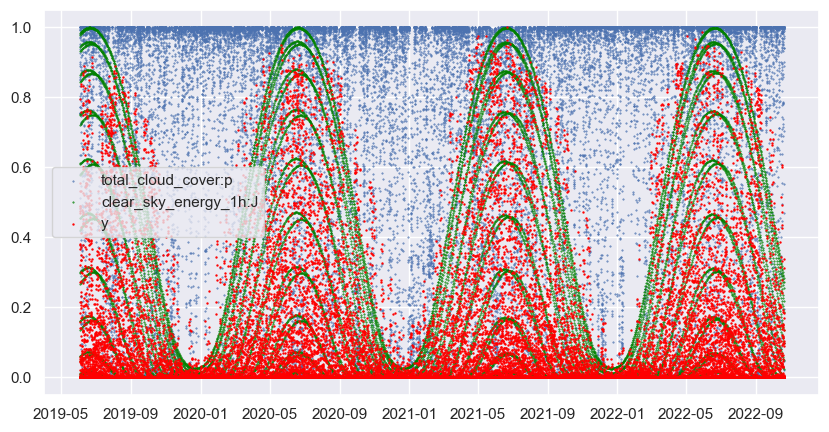

In [240]:
# EDA

train_normalized = (train - train.min()) / (train.max() - train.min())

fig, ax = plt.subplots(figsize=(10, 5))

plt.scatter(train_normalized.index, train_normalized["total_cloud_cover:p"], s=0.2)
# plt.scatter(train_normalized.index, train_normalized["sun_elevation:d"], s=0.2)
plt.scatter(train_normalized.index, train_normalized["clear_sky_energy_1h:J"], s=0.2, c="green")
plt.scatter(train_normalized.index, train_normalized["y"], s=0.5, c="red")
ax.legend(["total_cloud_cover:p", "clear_sky_energy_1h:J", "y"])

print("Correlation Clear Sky Energy and y:")
print(np.corrcoef(train["clear_sky_energy_1h:J"], train["y"])[0][1])
print()
print("Correlation Cloud Cover and y:")
print(np.corrcoef(train["total_cloud_cover:p"], train["y"])[0][1])